In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
df = pd.read_csv('data1.csv')
print(df.shape)
df.head()

(27911, 38)


,id,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,dst_port,...,dst2src_bytes,application_name,application_category_name,application_is_guessed,application_confidence,requested_server_name,client_fingerprint,server_fingerprint,user_agent,content_type
0,0,0,fe80::8ca5:5eff:fe59:d0fe,8e:a5:5e:59:d0:fe,8e:a5:5e,0,ff02::2,33:33:00:00:00:02,33:33:00,0,...,0,ICMPV6,Network,0,6,NaN,NaN,NaN,NaN,NaN
1,1,0,fe80::ac98:aff:fe11:272f,ae:98:0a:11:27:2f,ae:98:0a,0,ff02::2,33:33:00:00:00:02,33:33:00,0,...,0,ICMPV6,Network,0,6,NaN,NaN,NaN,NaN,NaN
2,2,0,fe80::8ca5:5eff:fe59:d0fe,8e:a5:5e:59:d0:fe,8e:a5:5e,5353,ff02::fb,33:33:00:00:00:fb,33:33:00,5353,...,0,MDNS,Network,0,6,_ipps._tcp.local,NaN,NaN,NaN,NaN
3,3,0,fe80::ac98:aff:fe11:272f,ae:98:0a:11:27:2f,ae:98:0a,5353,ff02::fb,33:33:00:00:00:fb,33:33:00,5353,...,0,MDNS,Network,0,6,_ipps._tcp.local,NaN,NaN,NaN,NaN
4,4,0,10.0.0.104,00:00:00:00:00:04,00:00:00,57742,10.0.0.102,00:00:00:00:00:02,00:00:00,80,...,828,HTTP,Web,1,1,NaN,NaN,NaN,NaN,NaN


In [12]:
df.columns

Index(['id', 'expiration_id', 'src_ip', 'src_mac', 'src_oui', 'src_port',
       'dst_ip', 'dst_mac', 'dst_oui', 'dst_port', 'protocol', 'ip_version',
       'vlan_id', 'tunnel_id', 'bidirectional_first_seen_ms',
       'bidirectional_last_seen_ms', 'bidirectional_duration_ms',
       'bidirectional_packets', 'bidirectional_bytes', 'src2dst_first_seen_ms',
       'src2dst_last_seen_ms', 'src2dst_duration_ms', 'src2dst_packets',
       'src2dst_bytes', 'dst2src_first_seen_ms', 'dst2src_last_seen_ms',
       'dst2src_duration_ms', 'dst2src_packets', 'dst2src_bytes',
       'application_name', 'application_category_name',
       'application_is_guessed', 'application_confidence',
       'requested_server_name', 'client_fingerprint', 'server_fingerprint',
       'user_agent', 'content_type'],
      dtype='object')

In [13]:
# remove non IP packets
df = df[df['protocol'] == 6]
df.shape

(27895, 38)

In [14]:
# remove non IPv4 packets
df = df[df['ip_version'] == 4]
df.shape

(27895, 38)

In [15]:
df['application_name'].unique()

array(['HTTP', 'RSH'], dtype=object)

In [16]:
# see bidirectional_duration_ms distribution
df['bidirectional_duration_ms'].describe()

,bidirectional_duration_ms
count,27895.000000
mean,1411.125291
std,11078.567320
min,0.000000
25%,45.000000
50%,69.000000
75%,96.000000
max,194949.000000


0.3498891788807953
0.08556033777699668
(481,)


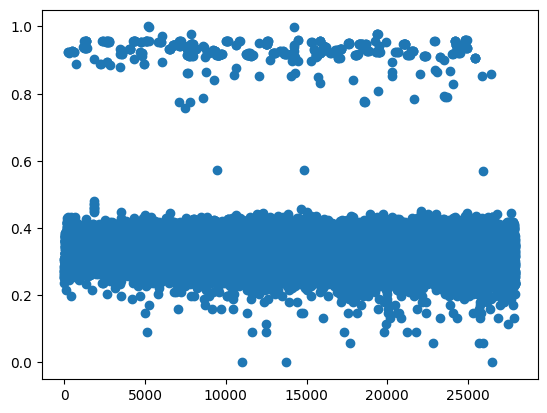

In [17]:
# Normalize bidirectional_duration_ms with log
#print(np.max(df['bidirectional_duration_ms']))
#print(np.min(df['bidirectional_duration_ms']))
log_normalized = np.log(df['bidirectional_duration_ms'] + 1)
# show stats
#print(np.max(log_normalized))
#print(np.min(log_normalized))
# Normalize to 0
log_mean = np.mean(log_normalized)
log_std = np.std(log_normalized)
normalized = (log_normalized - log_mean) / log_std

# Min max scale
log_max = np.max(log_normalized)
log_min = np.min(log_normalized)
normalized = (log_normalized - log_min) / (log_max - log_min)

#print(np.max(normalized))
#print(np.min(normalized))
#print(np.std(normalized))
# Count mean - std, -std to std, and mean + std
#print("Count mean - std: ", df[normalized < -1].shape[0])
#print("Count -std to std: ", df[(normalized >= -1) & (normalized < 1)].shape[0])
#print("Count mean + std: ", df[normalized >= 1].shape[0])


print(np.mean(normalized))
print(np.std(normalized))
print(np.where(normalized > np.mean(normalized) + np.std(normalized))[0].shape)

# Visualize
plt.plot(normalized, 'o')
plt.show()

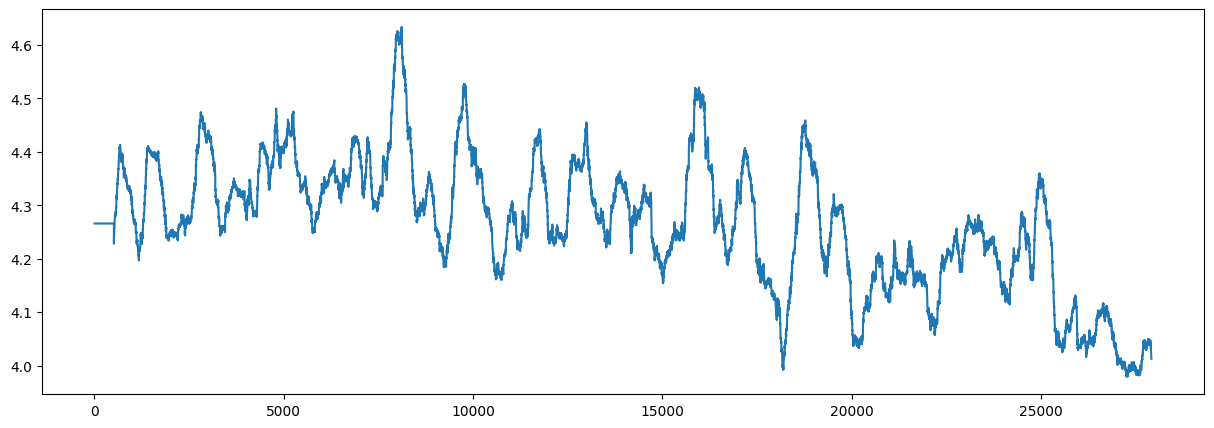

In [25]:
# Rolling average of log bidirectional_duration_ms
df_log = df.copy()
df_log['bidirectional_duration_ms'] = np.log(df_log['bidirectional_duration_ms'] + 1)
df_log['bidirectional_duration_ms'] = df_log['bidirectional_duration_ms'].rolling(window=512).mean()
df_log['bidirectional_duration_ms'] = df_log['bidirectional_duration_ms'].fillna(df_log['bidirectional_duration_ms'].mean())
# Set figure size
plt.figure(figsize=(15, 5))
# Plot bidirectional_duration_ms
plt.plot(df_log['bidirectional_duration_ms'])
plt.show()

In [26]:
# get autocorrelation
df_log['bidirectional_duration_ms'].autocorr()

0.9997164214554138

In [27]:
# Create a time series model to predict df_log
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_log['bidirectional_duration_ms'], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                                   SARIMAX Results                                   
Dep. Variable:     bidirectional_duration_ms   No. Observations:                27895
Model:                        ARIMA(1, 1, 1)   Log Likelihood              123796.796
Date:                       Wed, 11 Dec 2024   AIC                        -247587.592
Time:                               04:16:47   BIC                        -247562.883
Sample:                                    0   HQIC                       -247579.636
                                     - 27895                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5312      0.083      6.433      0.000       0.369       0.693
ma.L1         -0.4850      0.085     -5.673      0.000      -0.653      -0.

8.293101409934346e-06


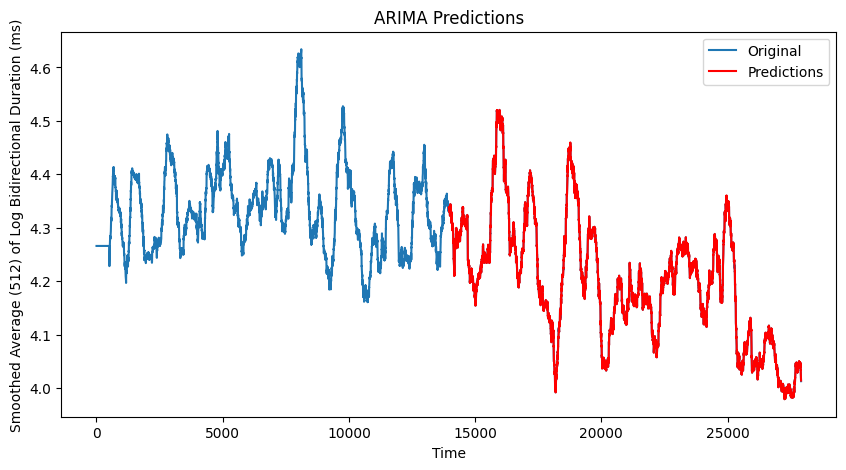

In [37]:
# predict half the data using the learned model
predictions = model_fit.predict(start=int(len(df_log)/2), end=len(df_log) - 1)
# plot in a different diagram
# set fig size
plt.figure(figsize=(10, 5))
# plot the original data
plt.plot(df_log['bidirectional_duration_ms'], label='Original')
# plot the predictions
plt.plot(predictions, color='red', label='Predictions')
plt.title('ARIMA Predictions')
plt.xlabel('Time')
plt.ylabel('Smoothed Average (512) of Log Bidirectional Duration (ms)')
plt.legend()

# calculate the loss
from sklearn.metrics import mean_squared_error
print(mean_squared_error(df_log['bidirectional_duration_ms'][int(len(df_log)/2):], predictions))

In [10]:
def preprocess_data(filename, lb):
    df = pd.read_csv(filename)
    df = df[df['protocol'] == 6]
    df = df[df['ip_version'] == 4]
    # reset index
    df = df.reset_index(drop=True)

    # sort by src2dst_first_seen_ms
    df = df.sort_values(by=['src2dst_first_seen_ms'])

    # put label
    #df['label'] = np.where(df['bidirectional_duration_ms'] < 100, 0, np.where(df['bidirectional_duration_ms'] < 1000, 1, 2))

    # Log normal
    df['label'] = np.log(df['bidirectional_duration_ms'] + 1)
    # Min Max Scaling
    label_max = np.max(df['label'])
    label_min = np.min(df['label'])
    df['label'] = (df['label'] - label_min) / (label_max - label_min)
    label_mean = np.mean(df['label'])
    label_std = np.std(df['label'])

    # Smoothed average of the label values
    df['label'] = df['label'].rolling(window=1000).mean()
    df['label'] = df['label'].fillna(df['label'].mean())

    # Every value that is greater than +1std is labelled 1, otherwise 0
    df['label'] = np.where(df['label'] > label_mean + label_std, 1, 0)

    df_filtered = df[
        [
        'bidirectional_duration_ms', 'bidirectional_packets', 'bidirectional_bytes',
        # 'src2dst_duration_ms', 'src2dst_packets', 'src2dst_bytes',
        # 'dst2src_duration_ms', 'dst2src_packets', 'dst2src_bytes',
        'src_ip', 'src_port',
        'dst_ip', 'dst_port',
        # 'protocol', 'ip_version', 'application_name',
        'label'
        ]]
    # One hot encode src_ip, dst_ip
    df_filtered = pd.get_dummies(df_filtered, columns=['src_ip','dst_ip'])
    # Convert all boolean one-hot encoded columns to integer
    df_filtered = df_filtered.astype(int)

    # Log normalize
    df_filtered['bidirectional_duration_ms'] = np.log(df_filtered['bidirectional_duration_ms'] + 1)
    df_filtered['bidirectional_duration_ms'] = (df_filtered['bidirectional_duration_ms'] - df_filtered['bidirectional_duration_ms'].mean()) / df_filtered['bidirectional_duration_ms'].std()
    df_filtered['bidirectional_packets'] = np.log(df_filtered['bidirectional_packets'] + 1)
    df_filtered['bidirectional_packets'] = (df_filtered['bidirectional_packets'] - df_filtered['bidirectional_packets'].mean()) / df_filtered['bidirectional_packets'].std()
    df_filtered['bidirectional_bytes'] = np.log(df_filtered['bidirectional_bytes'] + 1)
    df_filtered['bidirectional_bytes'] = (df_filtered['bidirectional_bytes'] - df_filtered['bidirectional_bytes'].mean()) / df_filtered['bidirectional_bytes'].std()

    """
    df_filtered['src2dst_duration_ms'] = np.log(df_filtered['src2dst_duration_ms'] + 1)
    df_filtered['src2dst_duration_ms'] = (df_filtered['src2dst_duration_ms'] - df_filtered['src2dst_duration_ms'].mean()) / df_filtered['src2dst_duration_ms'].std()
    df_filtered['src2dst_packets'] = np.log(df_filtered['src2dst_packets'] + 1)
    df_filtered['src2dst_packets'] = (df_filtered['src2dst_packets'] - df_filtered['src2dst_packets'].mean()) / df_filtered['src2dst_packets'].std()
    df_filtered['src2dst_bytes'] = np.log(df_filtered['src2dst_bytes'] + 1)
    df_filtered['src2dst_bytes'] = (df_filtered['src2dst_bytes'] - df_filtered['src2dst_bytes'].mean()) / df_filtered['src2dst_bytes'].std()
    df_filtered['dst2src_duration_ms'] = np.log(df_filtered['dst2src_duration_ms'] + 1)
    df_filtered['dst2src_duration_ms'] = (df_filtered['dst2src_duration_ms'] - df_filtered['dst2src_duration_ms'].mean()) / df_filtered['dst2src_duration_ms'].std()
    df_filtered['dst2src_packets'] = np.log(df_filtered['dst2src_packets'] + 1)
    df_filtered['dst2src_packets'] = (df_filtered['dst2src_packets'] - df_filtered['dst2src_packets'].mean()) / df_filtered['dst2src_packets'].std()
    df_filtered['dst2src_bytes'] = np.log(df_filtered['dst2src_bytes'] + 1)
    df_filtered['dst2src_bytes'] = (df_filtered['dst2src_bytes'] - df_filtered['dst2src_bytes'].mean()) / df_filtered['dst2src_bytes'].std()
    """

    # Normalize ports
    df_filtered['src_port'] /= 65535
    df_filtered['dst_port'] /= 65535

    # TODO: update scaler
    scaler = {
        #'bidirectional_duration_ms': (df_filtered['bidirectional_duration_ms'].mean(), df_filtered['bidirectional_duration_ms'].std()),
        #'bidirectional_packets': (df_filtered['bidirectional_packets'].mean(), df_filtered['bidirectional_packets'].std()),
        #'bidirectional_bytes': (df_filtered['bidirectional_bytes'].mean(), df_filtered['bidirectional_bytes'].std()),
        'src_port': (df_filtered['src_port'].mean(), df_filtered['src_port'].std()),
        'dst_port': (df_filtered['dst_port'].mean(), df_filtered['dst_port'].std()),
        #'label': (label_log_mean, label_log_std),
    }

    X = []
    y = []
    for i in range(df_filtered.shape[0] - lb):
        X.append(df_filtered.iloc[i:i+lb].values)
        y.append(df_filtered.iloc[i+lb]['label'])

    X = np.array(X)
    y = np.array(y)

    print(X.shape)
    print(np.unique(y, return_counts=True))
    _,  minor_class = np.unique(y, return_counts=True)

    # Get y indicies where y is 0
    y_indicies_0 = np.where(y == 0)[0]
    # Sample y_indicies_0 to match minor_class
    y_indicies_0 = np.random.choice(y_indicies_0, size=minor_class, replace=False)

    X = X[np.concatenate([y_indicies_0, np.where(y == 1)[0]])]
    y = y[np.concatenate([y_indicies_0, np.where(y == 1)[0]])]

    return X, y, scaler


X, y, scaler = preprocess_data('data1.csv', 64)
print(X.shape)
print(y.shape)

(27831, 64, 14)
(array([0.]), array([27831]))
(27831, 64, 14)
(27831,)


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        return out

In [ ]:
input_size = X.shape[2]
hidden_size = 128
num_layers = 8
output_size = 2

model = LSTM(input_size, hidden_size, num_layers, output_size)

# Put model on device
model.to(device)

epochs = 50
batch_size = 16
learning_rate = 4e-3

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

test_size = int(X.shape[0] * 0.2)
# Shuffle data
shuffle_indices = np.random.permutation(np.arange(len(X)))
X = X[shuffle_indices]
y = y[shuffle_indices]
# Split
X_train = torch.tensor(X[:-test_size]).float().to(device)
y_train = torch.tensor(y[:-test_size]).long().to(device)
X_test = torch.tensor(X[-test_size:]).float().to(device)
y_test = torch.tensor(y[-test_size:]).long().to(device)
# print(X_train.shape)
# print(y_train.shape, y_train.unique())
# print(X_test.shape)
# print(y_test.shape)

train_dataset = data_utils.TensorDataset(X_train, y_train)
train_loader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = data_utils.TensorDataset(X_test, y_test)
test_loader = data_utils.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, len(train_loader), loss.item()))

    # Test
    with torch.no_grad():
        # Calculate f1 score
        from sklearn.metrics import f1_score
        y_pred = []
        y_true = []
        for inputs, labels in test_loader:
            outputs = model(inputs)
            outputs = torch.softmax(outputs, dim=1)
            predicted = torch.argmax(outputs, dim=1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

        f1 = f1_score(y_true, y_pred, average='macro')
        print('Epoch [{}/{}], F1 Score: {:.4f}'.format(epoch+1, epochs, f1))


Epoch [1/50], Step [10/49], Loss: 0.5755
Epoch [1/50], Step [20/49], Loss: 0.6932
Epoch [1/50], Step [30/49], Loss: 0.6909
Epoch [1/50], Step [40/49], Loss: 0.6932
Epoch [1/50], F1 Score: 0.3043
Epoch [2/50], Step [10/49], Loss: 0.6843
Epoch [2/50], Step [20/49], Loss: 0.7046
Epoch [2/50], Step [30/49], Loss: 0.7034
Epoch [2/50], Step [40/49], Loss: 0.6934
Epoch [2/50], F1 Score: 0.3043
Epoch [3/50], Step [10/49], Loss: 0.7326
Epoch [3/50], Step [20/49], Loss: 0.6763
Epoch [3/50], Step [30/49], Loss: 0.7080
Epoch [3/50], Step [40/49], Loss: 0.6897
Epoch [3/50], F1 Score: 0.3043
Epoch [4/50], Step [10/49], Loss: 0.6932
Epoch [4/50], Step [20/49], Loss: 0.6932
Epoch [4/50], Step [30/49], Loss: 0.6933
Epoch [4/50], Step [40/49], Loss: 0.6997
Epoch [4/50], F1 Score: 0.3043
Epoch [5/50], Step [10/49], Loss: 0.6903
Epoch [5/50], Step [20/49], Loss: 0.6973
Epoch [5/50], Step [30/49], Loss: 0.6937
Epoch [5/50], Step [40/49], Loss: 0.7019
Epoch [5/50], F1 Score: 0.3043
Epoch [6/50], Step [10/49